### Process outline

1. Preprocess the data such as highly-variable gene filtering

See https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html for preprocessing

Use dandelion/dandelion/preprocessing/external/_preprocessing.py/recipe_scannpy_qc function to do preprocessing

2. Integration with Scanorama

See https://github.com/brianhie/scanorama for more info

See https://uci-genpals.github.io/integration/2020/12/03/scanorama_demo_pancreas.html for tutorial

In [1]:
# Environment set-up
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as anndata
import scipy as scipy
import seaborn as sbn
import matplotlib.pyplot as plt
from dandelion.preprocessing.external._preprocessing import recipe_scanpy_qc

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load all AnnData objects into a list

from pathlib import Path
from itertools import chain

GSE132509_directory = Path('/QRISdata/Q6104/Xiaohan/2_AnnData_objs/GSE132509')
GSE236351_directory = Path('/QRISdata/Q6104/Xiaohan/2_AnnData_objs/GSE236351')
GSE148218_directory = Path('/QRISdata/Q6104/Xiaohan/2_AnnData_objs/GSE148218')

combined_dirs = chain(GSE132509_directory.iterdir(), GSE236351_directory.iterdir(), GSE148218_directory.iterdir())
adatas = []
for adata_path in combined_dirs:
    if "_uni.h5ad" in adata_path.name:
        adata = anndata.read_h5ad(adata_path)
        adatas.append(adata)

print(len(adatas))
print(adatas[0])

26
AnnData object with n_obs × n_vars = 2229 × 33694
    obs: 'cancer_type', 'dataset', 'tissue', 'sample_barcode', 'uni_barcode'
    var: 'gene_ids'


In [5]:
# Find out common genes among all AnnData objects
common_genes = set(adatas[0].var_names)
for adata in adatas[1:]:
    common_genes.intersection_update(adata.var_names)
    print(len(common_genes))

33694
33694
33694
33694
33694
33694
33694
33694
33694
33694
14889
14718
14718
14718
14718
14718
14718
14071
14071
14071
14071
14071
14071
14071
14071


In [6]:
# Filter all AnnData objects with common genes
adatas_common_genes = []
for adata in adatas:
    adata_common_genes = adata[:, list(common_genes)]
    print(adata_common_genes.shape)
    adatas_common_genes.append(adata_common_genes)

(2229, 14071)
(1612, 14071)
(2748, 14071)
(3105, 14071)
(5069, 14071)
(3728, 14071)
(5013, 14071)
(6274, 14071)
(2776, 14071)
(2959, 14071)
(3862, 14071)
(1712, 14071)
(6916, 14071)
(6523, 14071)
(3731, 14071)
(3726, 14071)
(2942, 14071)
(4293, 14071)
(6123, 14071)
(4163, 14071)
(7826, 14071)
(7917, 14071)
(7160, 14071)
(4224, 14071)
(6106, 14071)
(7228, 14071)


In [ ]:
# Merge all AnnData objects to visualize the data before integration
adata_unintegrated = sc.AnnData.concatenate(*adatas_common_genes)

### <span style="color:yellow">**Attempt 1:**</span> find highly variable genes individually and then integrate

In [7]:
# Do the preprocessing

adatas_filtered = [] 

for adata in adatas_common_genes:
    adata.raw = adata
    print(adata.shape)

    # Do QC and filtering
    recipe_scanpy_qc(adata)
    adata = adata[adata.obs.filter_rna == 'False', :]
    print(adata.shape)

    # Do normalization
    sc.pp.normalize_total(adata, target_sum=1.0)

    # Do the log transformation
    sc.pp.log1p(adata)

    # Select highky-variable genes
    sc.pp.highly_variable_genes(
        adata,
        n_top_genes=5000,
        batch_key='sample_barcode'
    )
    adata = adata[:, adata.var.highly_variable]
    print(adata.shape)

    # Do the scaling
    sc.pp.scale(adata, max_value=10)

    adatas_filtered.append(adata)

(2229, 14071)
(267, 14071)
(267, 5000)
(1612, 14071)
(1243, 14071)
(1243, 5000)
(2748, 14071)
(1106, 14071)
(1106, 5000)
(3105, 14071)
(2181, 14071)
(2181, 5000)
(5069, 14071)
(3572, 14071)
(3572, 5000)
(3728, 14071)
(3243, 14071)
(3243, 5000)
(5013, 14071)
(2401, 14071)
(2401, 5000)
(6274, 14071)
(4217, 14071)
(4217, 5000)
(2776, 14071)
(2501, 14071)
(2501, 5000)
(2959, 14071)
(2533, 14071)
(2533, 5000)
(3862, 14071)
(1207, 14071)
(1207, 5000)
(1712, 14071)
(1267, 14071)
(1267, 5000)
(6916, 14071)
(6513, 14071)
(6513, 5000)
(6523, 14071)
(5458, 14071)
(5458, 5000)
(3731, 14071)
(3518, 14071)
(3518, 5000)
(3726, 14071)
(2527, 14071)
(2527, 5000)
(2942, 14071)
(2394, 14071)
(2394, 5000)
(4293, 14071)
(4149, 14071)
(4149, 5000)
(6123, 14071)
(680, 14071)
(680, 5000)
(4163, 14071)
(3263, 14071)
(3263, 5000)
(7826, 14071)
(6315, 14071)
(6315, 5000)
(7917, 14071)
(5697, 14071)
(5697, 5000)
(7160, 14071)
(5703, 14071)
(5703, 5000)
(4224, 14071)
(2890, 14071)
(2890, 5000)
(6106, 14071)
(4184,

In [9]:
print(len(adatas_filtered))
print(adatas_filtered[0])

26
AnnData object with n_obs × n_vars = 267 × 5000
    obs: 'cancer_type', 'dataset', 'tissue', 'sample_barcode', 'uni_barcode', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_pct_count_clusters_keep', 'scrublet_score', 'is_doublet', 'filter_rna'
    var: 'gene_ids', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'log1p', 'hvg'


In [10]:
import scanorama

# Integration and batch correction.
corrected = scanorama.correct_scanpy(adatas_filtered, return_dimred=True)

Found 208 genes among all datasets
[[0.         0.45318352 0.18726592 0.07865169 0.18726592 0.19475655
  0.12734082 0.09737828 0.05992509 0.07490637 0.09737828 0.13483146
  0.11985019 0.07865169 0.02621723 0.07490637 0.01498127 0.11235955
  0.         0.06367041 0.14606742 0.0411985  0.08988764 0.01872659
  0.03370787 0.05617978]
 [0.         0.         0.15189873 0.12630732 0.09895414 0.25100563
  0.07562349 0.09895414 0.04746581 0.08205953 0.02091714 0.12628256
  0.14561545 0.13354787 0.05068383 0.04424779 0.05390185 0.02735318
  0.00441176 0.03781175 0.09654063 0.2622687  0.0925181  0.02413516
  0.04263878 0.13032985]
 [0.         0.         0.         0.11211573 0.09041591 0.29023508
  0.14285714 0.16003617 0.08679928 0.1482821  0.02169982 0.12296564
  0.2477396  0.11934901 0.11301989 0.05786618 0.05153707 0.06148282
  0.00588235 0.06148282 0.06600362 0.10216998 0.05334539 0.02983725
  0.03616637 0.03887884]
 [0.         0.         0.         0.         0.16643741 0.043558
  0.0087

In [11]:
# Concatenate the integrated AnnData objects
adata_integrated = sc.AnnData.concatenate(*corrected)
print(adata_integrated)

AnnData object with n_obs × n_vars = 84496 × 208
    obs: 'cancer_type', 'dataset', 'tissue', 'sample_barcode', 'uni_barcode', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_pct_count_clusters_keep', 'scrublet_score', 'is_doublet', 'filter_rna', 'batch'
    var: 'highly_variable', 'highly_variable_nbatches', 'highly_variable_intersection', 'gene_ids-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'mean-0', 'std-0', 'gene_ids-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'mean-1', 'std-1', 'gene_ids-10', 'means-10', 'dispersions-10', 'dispersions_norm-10', 'mean-10', 'std-10', 'gene_ids-11', 'means-11', 'dispersions-11', 'dispersions_norm-11', 'mean-11', 'std-11', 'feature_types-11', 'gene_ids-12', 'means-12', 'dispersions-12', 'dispersions_norm-12', 'mean-12', 'std-12', 'feature_types-12', 'gene_ids-13', 'means-13', 'dispersions-13', 'dispersions_norm-13', 'mean-13', 'std-13', 'feature_types-13', 'gene_ids-14', 'means-14', 'disper

In [12]:
# Another way to do UMAP by computing KNN graph first

sc.pp.neighbors(adata_integrated, use_rep='X_scanorama')
sc.tl.umap(adata_integrated)

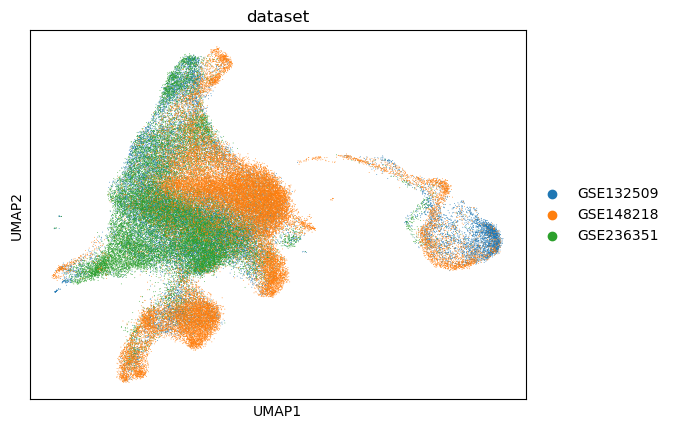

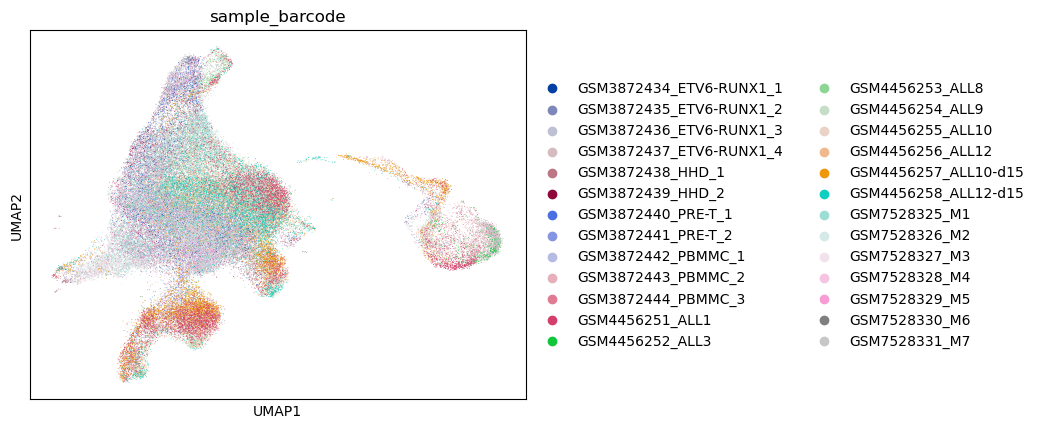

In [18]:
sc.pl.umap(adata_integrated, color=['dataset'])
sc.pl.umap(adata_integrated, color=['sample_barcode'])

In [19]:
# Before integration
sc.tl.pca(adata_unintegrated) # Calculate the PCA embeddings
sc.pp.neighbors(adata_unintegrated) # Determine the kNN graph
sc.tl.umap(adata_unintegrated) # Calculate the UMAP

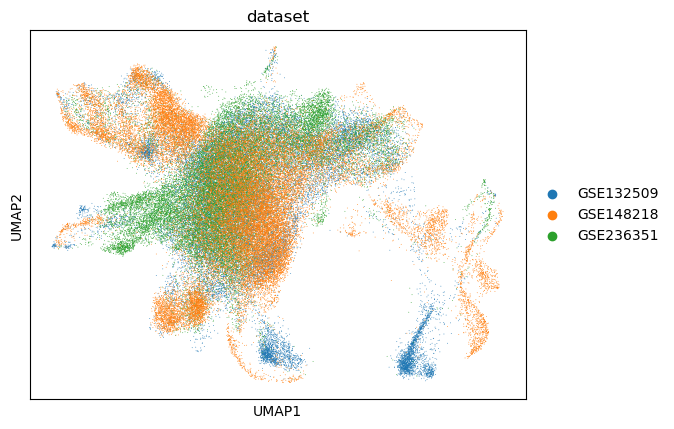

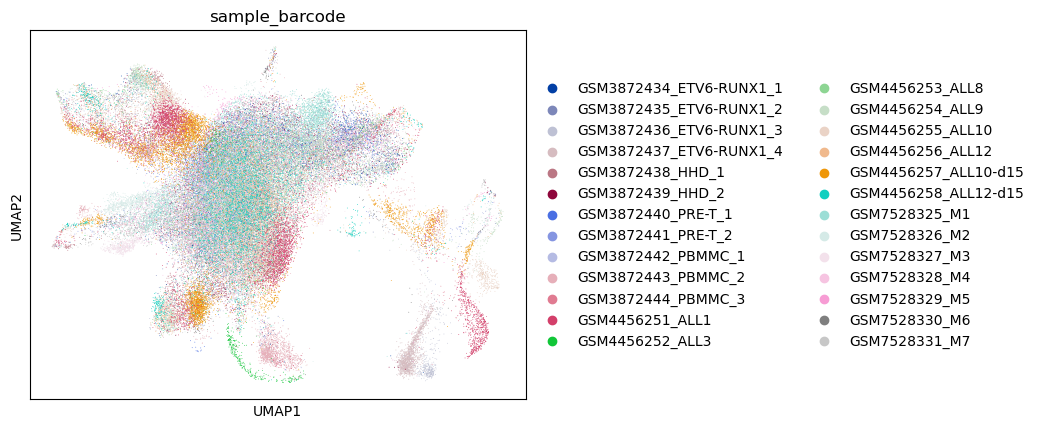

In [20]:
sc.pl.umap(adata_unintegrated, color=['dataset'])
sc.pl.umap(adata_unintegrated, color=['sample_barcode'])

### <span style="color:yellow">**Attempt 2:**</span> concatenate all AnnData objects and find highly variable genes together

In [21]:
# Do the preprocessing

adatas_filtered = [] 

for adata in adatas_common_genes:
    adata.raw = adata
    print(adata.shape)

    # Do QC and filtering
    recipe_scanpy_qc(adata)
    adata = adata[adata.obs.filter_rna == 'False', :]
    print(adata.shape)

    # Do normalization
    sc.pp.normalize_total(adata, target_sum=1.0)

    # Do the log transformation
    sc.pp.log1p(adata)

    adatas_filtered.append(adata)

(2229, 14071)
(1704, 14071)
(1612, 14071)
(1243, 14071)
(2748, 14071)
(1106, 14071)
(3105, 14071)
(2181, 14071)
(5069, 14071)
(3572, 14071)
(3728, 14071)
(3243, 14071)
(5013, 14071)
(2401, 14071)
(6274, 14071)
(4217, 14071)
(2776, 14071)
(2501, 14071)
(2959, 14071)
(2533, 14071)
(3862, 14071)
(1207, 14071)
(1712, 14071)
(1267, 14071)
(6916, 14071)
(6513, 14071)
(6523, 14071)
(5458, 14071)
(3731, 14071)
(3518, 14071)
(3726, 14071)
(2527, 14071)
(2942, 14071)
(2394, 14071)
(4293, 14071)
(4149, 14071)
(6123, 14071)
(680, 14071)
(4163, 14071)
(3263, 14071)
(7826, 14071)
(6315, 14071)
(7917, 14071)
(5697, 14071)
(7160, 14071)
(5703, 14071)
(4224, 14071)
(2890, 14071)
(6106, 14071)
(4184, 14071)
(7228, 14071)
(5467, 14071)


In [22]:
# Concatenate filtered AnnData objects into one to select highly variable genes
adatas_filtered_all = sc.AnnData.concatenate(*adatas_filtered)

target_genes = 1000
sc.pp.highly_variable_genes(adatas_filtered_all, n_top_genes=target_genes, batch_key='dataset')
adatas_filtered_all

AnnData object with n_obs × n_vars = 85933 × 14071
    obs: 'cancer_type', 'dataset', 'tissue', 'sample_barcode', 'uni_barcode', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_pct_count_clusters_keep', 'scrublet_score', 'is_doublet', 'filter_rna', 'batch'
    var: 'gene_ids-0', 'gene_ids-1', 'gene_ids-10', 'gene_ids-11', 'feature_types-11', 'gene_ids-12', 'feature_types-12', 'gene_ids-13', 'feature_types-13', 'gene_ids-14', 'feature_types-14', 'gene_ids-15', 'feature_types-15', 'gene_ids-16', 'feature_types-16', 'gene_ids-17', 'feature_types-17', 'gene_ids-18', 'feature_types-18', 'gene_ids-19', 'feature_types-19', 'gene_ids-2', 'gene_ids-20', 'feature_types-20', 'gene_ids-21', 'feature_types-21', 'gene_ids-22', 'feature_types-22', 'gene_ids-23', 'feature_types-23', 'gene_ids-24', 'feature_types-24', 'gene_ids-25', 'feature_types-25', 'gene_ids-3', 'gene_ids-4', 'gene_ids-5', 'gene_ids-6', 'gene_ids-7', 'gene_ids-8', 'gene_ids-9', 'highly_varia

In [24]:
adatas_filtered_all.obs

,cancer_type,dataset,tissue,sample_barcode,uni_barcode,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,gmm_pct_count_clusters_keep,scrublet_score,is_doublet,filter_rna,batch
uni_barcode,,,,,,,,,,,,,,,
GSE132509_AAACCTGAGGACAGCT-1-0,Healthy,GSE132509,bone_marrow,GSM3872444_PBMMC_3,GSE132509_AAACCTGAGGACAGCT-1,638,638,2099.0,62.0,2.953788,True,0.038509,False,False,0
GSE132509_AAACCTGAGGTACTCT-1-0,Healthy,GSE132509,bone_marrow,GSM3872444_PBMMC_3,GSE132509_AAACCTGAGGTACTCT-1,864,864,2302.0,114.0,4.952215,True,0.025974,False,False,0
GSE132509_AAACCTGCATCAGTCA-1-0,Healthy,GSE132509,bone_marrow,GSM3872444_PBMMC_3,GSE132509_AAACCTGCATCAGTCA-1,1355,1355,3159.0,103.0,3.260525,True,0.061350,False,False,0
GSE132509_AAACGGGCACCAGTTA-1-0,Healthy,GSE132509,bone_marrow,GSM3872444_PBMMC_3,GSE132509_AAACGGGCACCAGTTA-1,722,722,2072.0,56.0,2.702703,True,0.157025,False,False,0
GSE132509_AAACGGGGTACCTACA-1-0,Healthy,GSE132509,bone_marrow,GSM3872444_PBMMC_3,GSE132509_AAACGGGGTACCTACA-1,1116,1116,2980.0,188.0,6.308725,True,0.034565,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSE148218_TTTGTCAGTGTTTGGT-1-25,acute_lymphoblastic_leukemia,GSE148218,bone_marrow,GSM4456251_ALL1,GSE148218_TTTGTCAGTGTTTGGT-1,615,615,2566.0,40.0,1.558846,True,0.038651,False,False,25
GSE148218_TTTGTCATCACTATTC-1-25,acute_lymphoblastic_leukemia,GSE148218,bone_marrow,GSM4456251_ALL1,GSE148218_TTTGTCATCACTATTC-1,1109,1109,3818.0,152.0,3.981142,True,0.198516,False,False,25
GSE148218_TTTGTCATCACTCTTA-1-25,acute_lymphoblastic_leukemia,GSE148218,bone_marrow,GSM4456251_ALL1,GSE148218_TTTGTCATCACTCTTA-1,1253,1253,4592.0,90.0,1.959930,True,0.080160,False,False,25


In [25]:
# As we don't have enough target genes, we need to consider the 'next best' HVGs
n_batches = len(adatas_filtered_all.obs['sample_barcode'].cat.categories)

# These are the genes that are variable across all batches
nbatch1_dispersions = adatas_filtered_all.var['dispersions_norm'][adatas_filtered_all.var.highly_variable_nbatches > n_batches - 1]
nbatch1_dispersions.sort_values(ascending=False, inplace=True)
print(len(nbatch1_dispersions))

0


In [26]:
# Fill up the genes now, using this method from the Theis lab
enough = False
hvg = nbatch1_dispersions.index[:]
not_n_batches = 1

# We'll go down one by one, until we're selecting HVGs from just a single batch.
while not enough:

    target_genes_diff = target_genes - len(hvg) # Get the number of genes we still need to fill up

    tmp_dispersions = adatas_filtered_all.var['dispersions_norm'][adatas_filtered_all.var.highly_variable_nbatches == (n_batches - not_n_batches)]

    # If we haven't hit the target gene numbers, add this to the list and we repeat this iteration
    if len(tmp_dispersions) < target_genes_diff:

        hvg = hvg.append(tmp_dispersions.index)
        not_n_batches += 1

    else:

        tmp_dispersions.sort_values(ascending=False, inplace=True)
        hvg = hvg.append(tmp_dispersions.index[:target_genes_diff])
        enough = True

In [27]:
# Subset the meta AnnData object on the highly variable genes
adatas_filtered_hvg_all = adatas_filtered_all[:, hvg]

In [28]:
adatas_filtered_hvg_all

View of AnnData object with n_obs × n_vars = 85933 × 1000
    obs: 'cancer_type', 'dataset', 'tissue', 'sample_barcode', 'uni_barcode', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_pct_count_clusters_keep', 'scrublet_score', 'is_doublet', 'filter_rna', 'batch'
    var: 'gene_ids-0', 'gene_ids-1', 'gene_ids-10', 'gene_ids-11', 'feature_types-11', 'gene_ids-12', 'feature_types-12', 'gene_ids-13', 'feature_types-13', 'gene_ids-14', 'feature_types-14', 'gene_ids-15', 'feature_types-15', 'gene_ids-16', 'feature_types-16', 'gene_ids-17', 'feature_types-17', 'gene_ids-18', 'feature_types-18', 'gene_ids-19', 'feature_types-19', 'gene_ids-2', 'gene_ids-20', 'feature_types-20', 'gene_ids-21', 'feature_types-21', 'gene_ids-22', 'feature_types-22', 'gene_ids-23', 'feature_types-23', 'gene_ids-24', 'feature_types-24', 'gene_ids-25', 'feature_types-25', 'gene_ids-3', 'gene_ids-4', 'gene_ids-5', 'gene_ids-6', 'gene_ids-7', 'gene_ids-8', 'gene_ids-9', 'highl

In [29]:
# Visualize the data before integration
sc.tl.pca(adatas_filtered_hvg_all) # Calculate the PCA embeddings
sc.pp.neighbors(adatas_filtered_hvg_all) # Determine the kNN graph
sc.tl.umap(adatas_filtered_hvg_all) # Calculate the UMAP

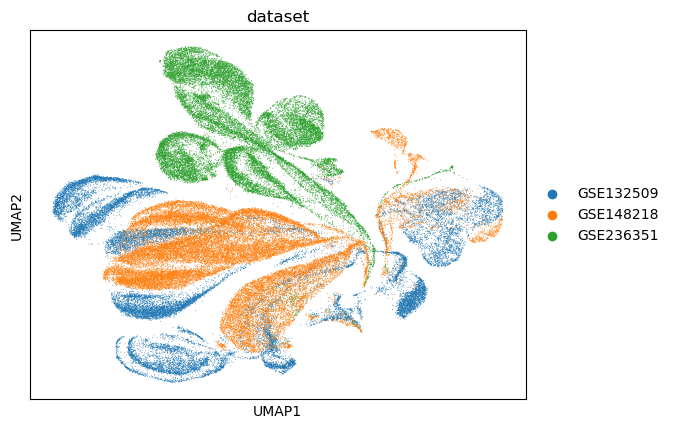

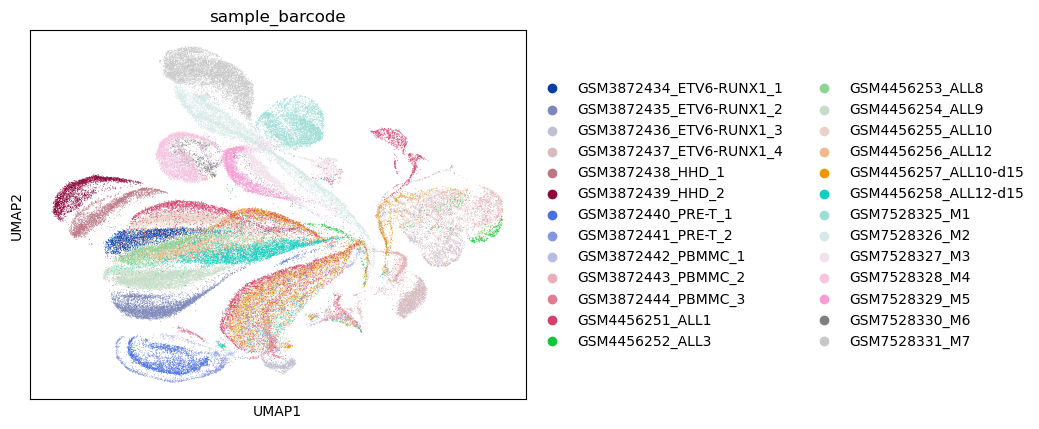

In [30]:
sc.pl.umap(adatas_filtered_hvg_all, color=['dataset'])
sc.pl.umap(adatas_filtered_hvg_all, color=['sample_barcode'])

In [31]:
# Split the meta AnnData
adatas_filtered_hvg = []

for batch in adatas_filtered_hvg_all.obs['batch'].unique():
    adatas_filtered_hvg.append(adatas_filtered_hvg_all[adatas_filtered_hvg_all.obs['batch']==batch].copy())

print(len(adatas_filtered_hvg))
print(adatas_filtered_hvg[0])

26
AnnData object with n_obs × n_vars = 1704 × 1000
    obs: 'cancer_type', 'dataset', 'tissue', 'sample_barcode', 'uni_barcode', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_pct_count_clusters_keep', 'scrublet_score', 'is_doublet', 'filter_rna', 'batch'
    var: 'gene_ids-0', 'gene_ids-1', 'gene_ids-10', 'gene_ids-11', 'feature_types-11', 'gene_ids-12', 'feature_types-12', 'gene_ids-13', 'feature_types-13', 'gene_ids-14', 'feature_types-14', 'gene_ids-15', 'feature_types-15', 'gene_ids-16', 'feature_types-16', 'gene_ids-17', 'feature_types-17', 'gene_ids-18', 'feature_types-18', 'gene_ids-19', 'feature_types-19', 'gene_ids-2', 'gene_ids-20', 'feature_types-20', 'gene_ids-21', 'feature_types-21', 'gene_ids-22', 'feature_types-22', 'gene_ids-23', 'feature_types-23', 'gene_ids-24', 'feature_types-24', 'gene_ids-25', 'feature_types-25', 'gene_ids-3', 'gene_ids-4', 'gene_ids-5', 'gene_ids-6', 'gene_ids-7', 'gene_ids-8', 'gene_ids-9', 'highly_vari

In [32]:
# Now we run Scanorama on the split data.
import scanorama

corrected = scanorama.correct_scanpy(adatas_filtered_hvg, return_dimred=True)

# Concatenate the integrated AnnData objects
adata_integrated = sc.AnnData.concatenate(*corrected)
print(adata_integrated)

Found 1000 genes among all datasets
[[0.00000000e+00 4.40868866e-01 1.43761302e-01 2.72887324e-01
  2.64277716e-01 2.52347418e-02 1.87793427e-02 1.63145540e-01
  1.76056338e-03 1.34976526e-02 3.56255178e-01 3.93192488e-02
  5.86854460e-04 4.10798122e-03 2.34741784e-03 0.00000000e+00
  5.10563380e-02 1.17370892e-03 1.45588235e-01 1.40845070e-02
  6.33802817e-02 8.97887324e-02 5.34037559e-02 2.46478873e-02
  3.99061033e-02 2.93427230e-02]
 [0.00000000e+00 0.00000000e+00 2.80289331e-01 2.25261464e-02
  2.32362822e-02 2.42960579e-01 1.68946098e-02 3.78117458e-02
  4.35825670e-02 7.81681800e-02 5.79950290e-03 5.44593528e-02
  6.43604183e-03 1.36765889e-02 4.26378624e-03 0.00000000e+00
  7.05931495e-02 1.28720837e-02 2.05882353e-02 2.73531778e-02
  6.67739340e-02 1.69750603e-01 5.14883347e-02 1.85036203e-02
  5.87288817e-02 3.53982301e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.25497288e-02
  3.69540873e-02 3.25497288e-02 8.13743219e-03 2.71247740e-02
  1.62748644e-02 5.94032550e-0

In [33]:
# Do the UMAP to visualize the integration results
sc.pp.neighbors(adata_integrated, use_rep='X_scanorama')
sc.tl.umap(adata_integrated)

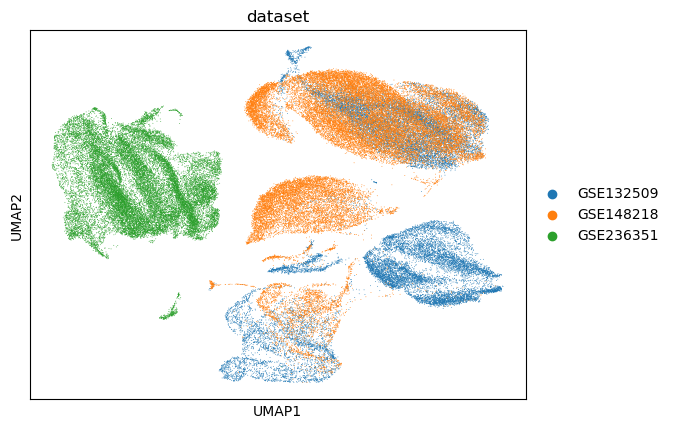

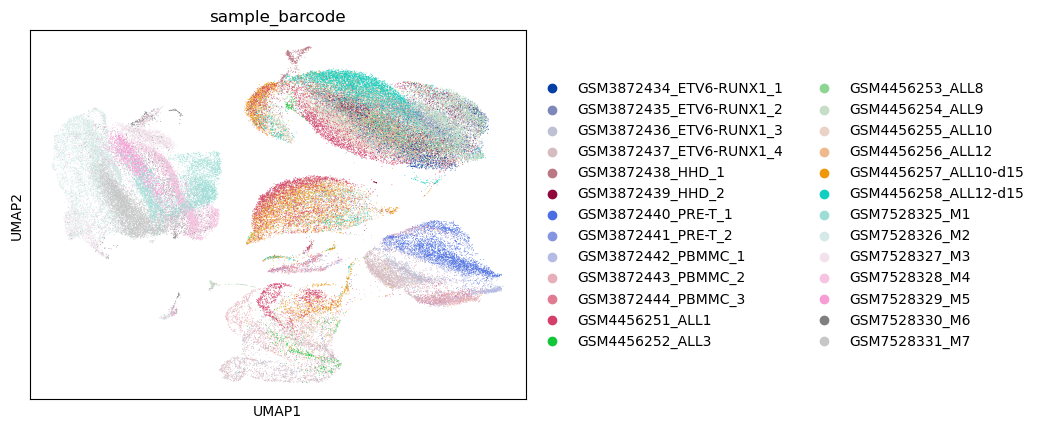

In [34]:
sc.pl.umap(adata_integrated, color=['dataset'])
sc.pl.umap(adata_integrated, color=['sample_barcode'])

### <span style="color:yellow">**Attempt 3:**</span> concatenate all AnnData objects and find highly variable genes together and scale individually

In [35]:
# The preprocessing is the same as Attempt 2,
# but before integration, we scale the gene expression of the meta AnnData

sc.pp.scale(adatas_filtered_hvg_all, max_value=10)

# Visualize the data before integration
sc.tl.pca(adatas_filtered_hvg_all) # Calculate the PCA embeddings
sc.pp.neighbors(adatas_filtered_hvg_all) # Determine the kNN graph
sc.tl.umap(adatas_filtered_hvg_all) # Calculate the UMAP

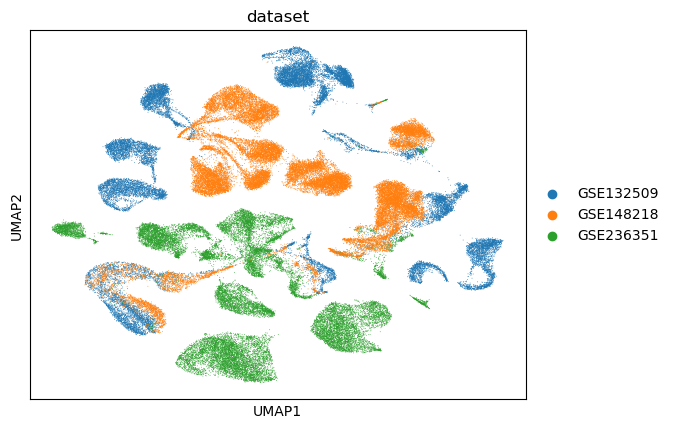

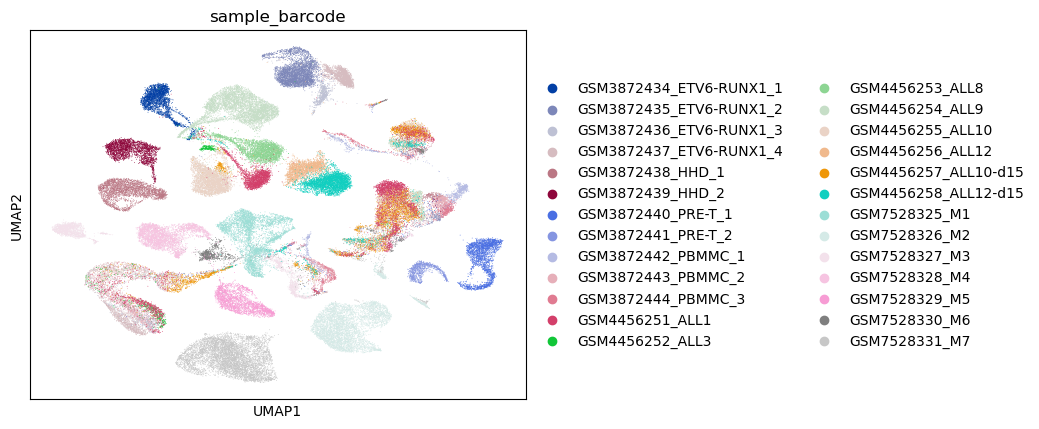

In [36]:
sc.pl.umap(adatas_filtered_hvg_all, color=['dataset'])
sc.pl.umap(adatas_filtered_hvg_all, color=['sample_barcode'])

In [37]:
# Split the meta AnnData
adatas_filtered_hvg_scaled = []

for batch in adatas_filtered_hvg_all.obs['batch'].unique():
    adatas_filtered_hvg_scaled.append(adatas_filtered_hvg_all[adatas_filtered_hvg_all.obs['batch']==batch].copy())

print(len(adatas_filtered_hvg_scaled))
print(adatas_filtered_hvg_scaled[0])

26
AnnData object with n_obs × n_vars = 1704 × 1000
    obs: 'cancer_type', 'dataset', 'tissue', 'sample_barcode', 'uni_barcode', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_pct_count_clusters_keep', 'scrublet_score', 'is_doublet', 'filter_rna', 'batch'
    var: 'gene_ids-0', 'gene_ids-1', 'gene_ids-10', 'gene_ids-11', 'feature_types-11', 'gene_ids-12', 'feature_types-12', 'gene_ids-13', 'feature_types-13', 'gene_ids-14', 'feature_types-14', 'gene_ids-15', 'feature_types-15', 'gene_ids-16', 'feature_types-16', 'gene_ids-17', 'feature_types-17', 'gene_ids-18', 'feature_types-18', 'gene_ids-19', 'feature_types-19', 'gene_ids-2', 'gene_ids-20', 'feature_types-20', 'gene_ids-21', 'feature_types-21', 'gene_ids-22', 'feature_types-22', 'gene_ids-23', 'feature_types-23', 'gene_ids-24', 'feature_types-24', 'gene_ids-25', 'feature_types-25', 'gene_ids-3', 'gene_ids-4', 'gene_ids-5', 'gene_ids-6', 'gene_ids-7', 'gene_ids-8', 'gene_ids-9', 'highly_vari

In [38]:
# Now we run Scanorama on the split data.
import scanorama

corrected = scanorama.correct_scanpy(adatas_filtered_hvg_scaled, return_dimred=True)

# Concatenate the integrated AnnData objects
adata_integrated_scaled = sc.AnnData.concatenate(*corrected)
print(adata_integrated_scaled)

Found 1000 genes among all datasets
[[0.00000000e+00 6.65325825e-01 1.44366197e-01 5.69248826e-01
  1.98356808e-01 1.10915493e-01 3.57981221e-02 1.82511737e-01
  1.29107981e-02 3.75586854e-02 1.26173709e-01 3.70955012e-02
  2.93427230e-03 4.10798122e-03 6.45539906e-03 2.34741784e-03
  8.80281690e-03 5.86854460e-04 1.52941176e-01 1.29107981e-02
  5.39906103e-02 6.10328638e-02 4.16666667e-02 9.38967136e-03
  2.64084507e-02 2.99295775e-02]
 [0.00000000e+00 0.00000000e+00 1.56878520e-01 3.42719228e-01
  1.76991150e-02 2.59855189e-01 9.65406275e-03 1.60901046e-03
  6.43604183e-03 8.84955752e-03 8.04505229e-03 3.21802092e-02
  3.21802092e-03 2.41351569e-03 2.41351569e-03 8.04505229e-04
  3.21637427e-02 2.41351569e-03 3.82352941e-02 1.28720837e-02
  2.81576830e-02 6.11423974e-02 2.41351569e-02 2.33306516e-02
  3.37892196e-02 4.98793242e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 7.24438331e-02
  9.04159132e-03 2.80289331e-02 2.07956600e-02 1.53707052e-02
  6.32911392e-03 3.19168174e-0

In [39]:
# Do the UMAP to visualize the integration results
sc.pp.neighbors(adata_integrated_scaled, use_rep='X_scanorama')
sc.tl.umap(adata_integrated_scaled)

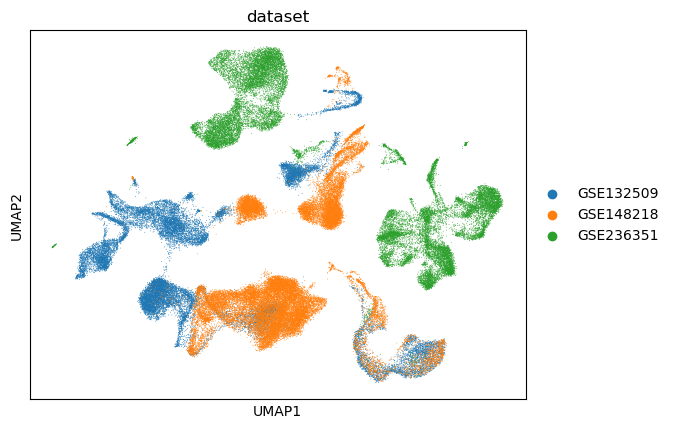

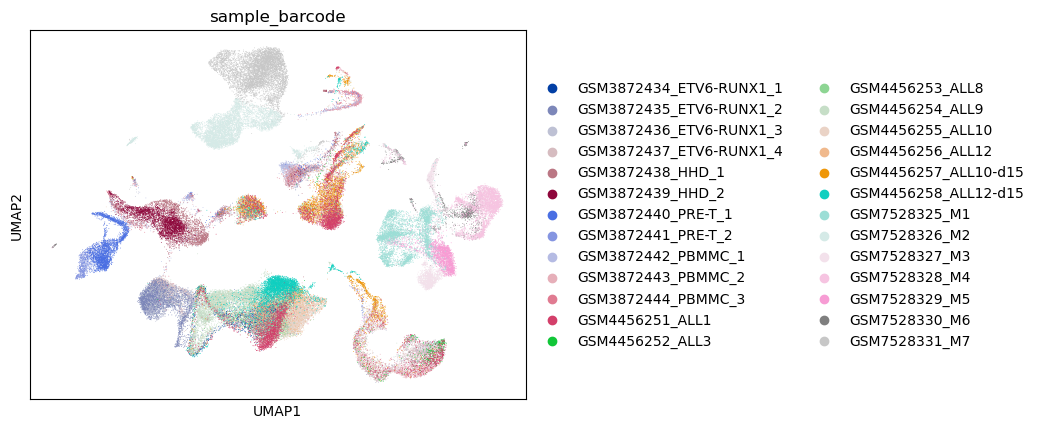

In [40]:
sc.pl.umap(adata_integrated_scaled, color=['dataset'])
sc.pl.umap(adata_integrated_scaled, color=['sample_barcode'])